In [1]:
from DS_healpix_fragmentation import *
from DS_WCS_projections import show_pic
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from skimage.filters import gaussian
import pandas as pd
from astropy.table import Table
from tqdm.notebook import tqdm
from threading import Thread

In [2]:
ra, dec, radius = 194.9356, 28.0256, 1.1
big_nside, big_ipix = find_biggest_pixel(ra, dec, radius)
depth = 12
small_nside = big_nside * (2 ** depth)
small_nside

32768

In [2]:
big_matr = one_pixel_fragmentation(big_nside, big_ipix, depth)
big_dict = matr2dict(big_matr)
circle_coords = draw_proper_circle(ra, dec, small_nside, big_matr.shape, big_dict, radius)
small_matr = zoom_to_circle(circle_coords, big_matr)
small_dict = matr2dict(small_matr)
small_circle_pic = draw_proper_circle(ra, dec, small_nside, list(small_matr.shape) + [1], 
                                      small_dict, radius / 5, mode='pic')

In [9]:
desi_lis_data = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree.csv')

In [10]:
desi_lis_data.head()

,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,...,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS,phot_is_star_gaia
0,8000,483713,1944p275,0,DEV,194.370715,27.376434,7.766236e+10,5.132580e+10,0.010509,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,8000,483713,1944p275,1,PSF,194.375536,27.377389,6.551291e+10,5.075641e+10,0.010561,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,4096,0
2,8000,483713,1944p275,3,REX,194.377318,27.377674,8.259466e+09,7.358640e+09,0.010576,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,8000,483713,1944p275,4,REX,194.368014,27.376374,1.218444e+10,1.040580e+10,0.010495,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,8000,483713,1944p275,5,PSF,194.376378,27.378784,1.483136e+09,1.303248e+09,0.010614,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [6]:
data_pic = np.zeros(list(small_matr.shape) + [3])

In [20]:
ipix = radec2pix(np.array(desi_lis_data['RA']), np.array(desi_lis_data['DEC']), 
                 small_nside)
for i in tqdm(range(desi_lis_data.shape[0])):
    pix = ipix[i]
    if pix in small_dict:
        x, y = small_dict[pix]
        for i, ch in enumerate(['FLUX_G', 'FLUX_R', 'FLUX_Z']):
            data_pic[x, y, i] = max(data_pic[x, y, i], desi_lis_data[ch][i])

<ipython-input-30-3621d1153c9b>:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  show_pic(gaussian(data_pic, 50))


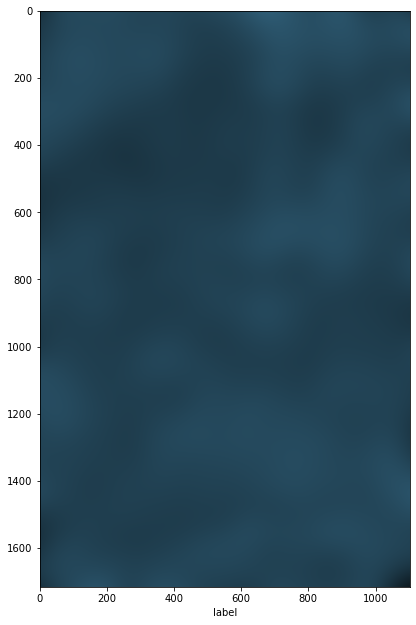

In [30]:
show_pic(gaussian(data_pic, 50))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


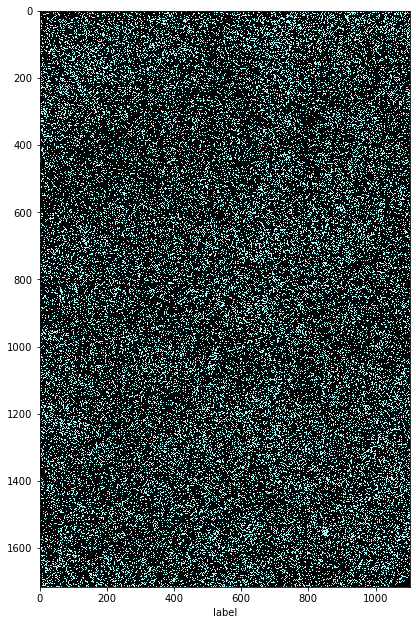

In [31]:
show_pic(data_pic)

In [79]:
max_data = np.zeros(list(small_matr.shape) + [3])
max_flux = 10000
np.count_nonzero(desi_lis_data['FLUX_G'] > max_flux)

5

In [80]:
bright_obj = desi_lis_data[desi_lis_data['FLUX_G'] > max_flux]
bright_obj.index = np.arange(bright_obj.shape[0])

max_data = np.zeros(list(small_matr.shape) + [3])
ipix = radec2pix(np.array(bright_obj['RA']), np.array(bright_obj['DEC']), 
                 small_nside)
for i in tqdm(range(bright_obj.shape[0])):
    pix = ipix[i]
    if pix in small_dict:
        x, y = small_dict[pix]
        for i, ch in enumerate(['FLUX_G', 'FLUX_R', 'FLUX_Z']):
            max_data[x, y, i] = max(max_data[x, y, i],
                                    bright_obj[ch][i])

<ipython-input-81-426c6293e802>:1: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  show_pic(gaussian(max_data, 5))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


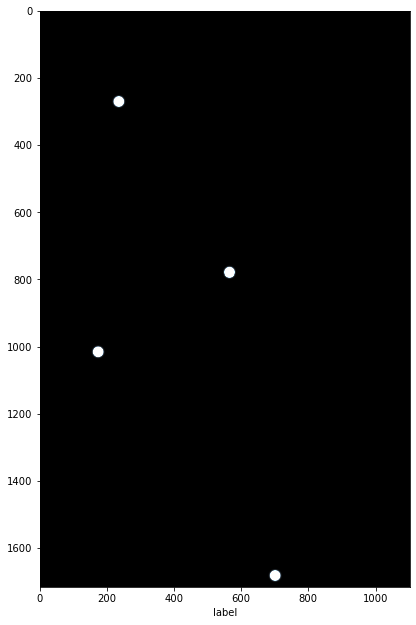

In [81]:
show_pic(gaussian(max_data, 5))

In [1]:
def nth_max(array, n):
    return np.partition(array, -n)[-n]

In [5]:
nth_max([1, 4, 6, 2, 3, 5], 3)

4

In [6]:
def n_max_flux(flux, n):
    max_n = nth_max(np.array(flux), n)
    return flux >= max_n

In [7]:
def n_max_flux_df(df, n, ch):
    ch = df[ch]
    return df[n_max_flux(ch, n)]

In [3]:
coma_projection = pd.DataFrame({'pix' : [], 'x' : [], 'y' : []}, dtype=int)
coma_projection.head()

,pix,x,y


In [4]:
for x in tqdm(range(small_matr.shape[0])):
    for y in range(small_matr.shape[1]):
        pix = small_matr[x, y]
        i = coma_projection.shape[0]
        coma_projection.loc[i] = [pix, x, y]

KeyboardInterrupt: 

In [34]:
def thread_func(df, x_st, step):
    for x in tqdm(range(x_st, small_matr.shape[0], step)):
        for y in range(small_matr.shape[1]):
            pix = small_matr[x, y]
            i = df.shape[0]
            df.loc[i] = [pix, x, y]

In [35]:
n_thread = 8
threads = []
for x_st in range(n_thread):
    df = pd.DataFrame({'pix' : [], 'x' : [], 'y' : []}, dtype=int)
    th = Thread(target=thread_func, args=(df, x_st, n_thread))
    th.start()
    threads.append((th, df))
for th, df in threads:
    th.join()
    coma_projection = pd.concat([coma_projection, df])

KeyboardInterrupt: 

In [5]:
np.save('/home/rt2122/Data/coma_sweep/south/small_matr', small_matr)